In [1]:
import torch
from matplotlib.pylab import plt
import math
torch.set_default_device('cuda')

In [2]:
N = 512
M = 128

In [3]:
W1 = []
W2 = []
for i in range(5):
    W1.append(torch.randn([N,M]))
    W2.append(W1[i] +  + torch.randn([N,M]) / 10)

### Single Experiment

In [4]:
def exp(params, forward):
    
    for e in range(5):
        optimiser = torch.optim.Adam(params, lr = 1e-3)
        criteria = torch.nn.MSELoss()

        losses = []
        iterations = []

        for i in range(10001):

            optimiser.zero_grad()
            loss = criteria(W2[e], forward(params, W1[e]))
            loss.backward()
            optimiser.step()

            if i%10==0:
                losses.append(float(loss))
                iterations.append(i)

        plt.plot(iterations, losses)
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

        print(loss)

### Experiment for ranks

In [5]:
def rank_exp(dim, forward, init):
    # dim is dimension of (AB)
    
    for exp in range(5):
        all_losses = []
        ranks = []

        R = 1
        while R<=min(dim[0], dim[1]):

            print('#' * 5 + ' Rank ' + str(R) + '#' * 5)

            A1 = torch.nn.Parameter(torch.zeros([dim[0],R]))
            B1 = torch.nn.Parameter(torch.zeros([R,dim[1]]))

            params = [A1, B1]
            init(params)

            optimiser = torch.optim.Adam(params, lr = 1e-3)
            criteria = torch.nn.MSELoss()

            losses = []
            iterations = []

            for i in range(10001):

                optimiser.zero_grad()
                loss = criteria(W2[exp], forward(params, W1[exp]))
                loss.backward()
                optimiser.step()

                if i%10==0:
                    iterations.append(i)
                    losses.append(float(loss))

            print(loss)
            plt.plot(iterations, losses, label = 'Rank ' + str(R))

            R=R*2

        plt.legend()
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

### Initialise

In [6]:
def init_lora_matrices(A, B):
    with torch.no_grad():
        torch.nn.init.kaiming_normal_(A)
        torch.nn.init.zeros_(B)
        
def init_mult_lora_matrices(A, B):
    torch.nn.init.kaiming_normal_(A)
    with torch.no_grad():
        A_t = A.t()
        B.copy_(torch.matmul(torch.inverse(torch.matmul(A_t, A)), A_t))
        
def init_shift_lora_matrices(A, B):
    with torch.no_grad():
        torch.nn.init.kaiming_normal_(A)
        torch.nn.init.zeros_(B)
        B[0][0] = 1
        A[:, 0] = 1

### Shift

In [7]:
shift_indices = None

def set_shift_indices(r, c):
    global shift_indices
    shift_indices = torch.zeros([r,c], dtype=torch.int64)
    for i in range(r):
        for j in range(c):
            shift_indices[i][j] = (j - i)%c

def shift(M):
    n_rows, n_cols = M.shape
    global shift_indices
    return torch.gather(M, 1, shift_indices)

### Pre Mult Full

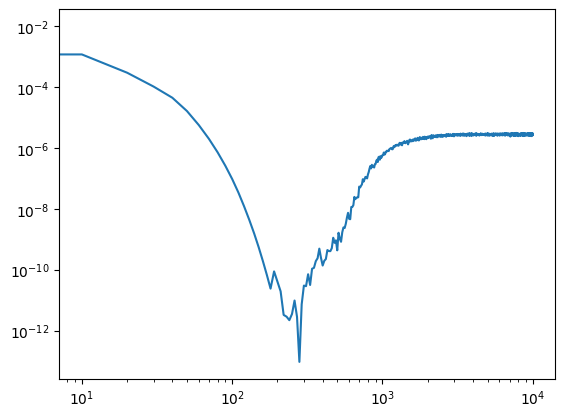

tensor(2.6764e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


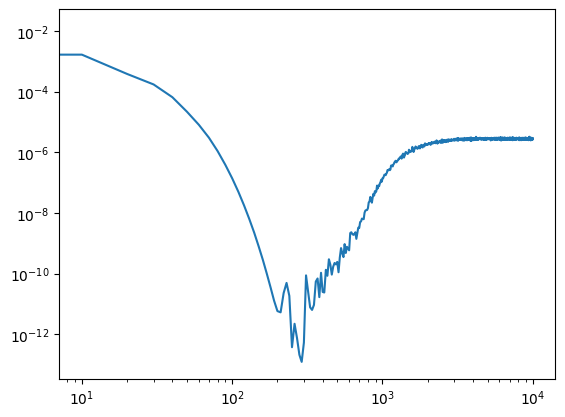

tensor(2.6889e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


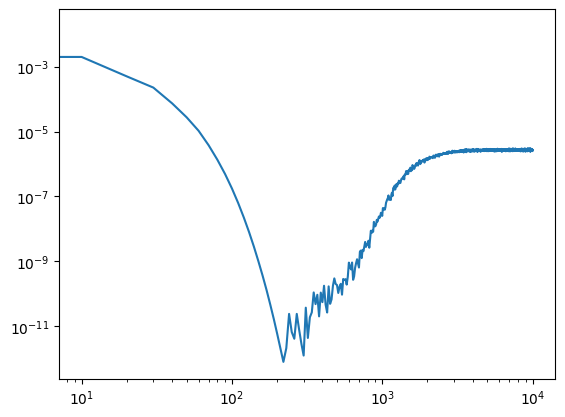

tensor(2.6218e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


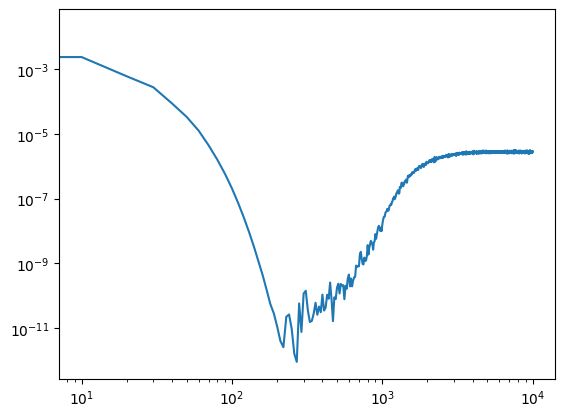

tensor(2.8951e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


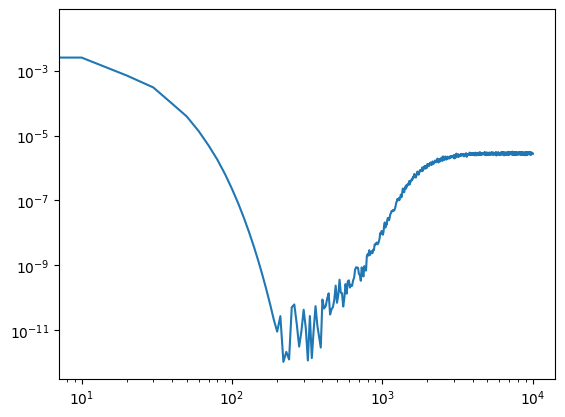

tensor(2.7310e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


In [8]:
A_pre = torch.nn.Parameter(torch.eye(N))

def forward(params, W1):
    return params[0] @ W1

params = [A_pre]
exp(params, forward)

### Post Mult Full

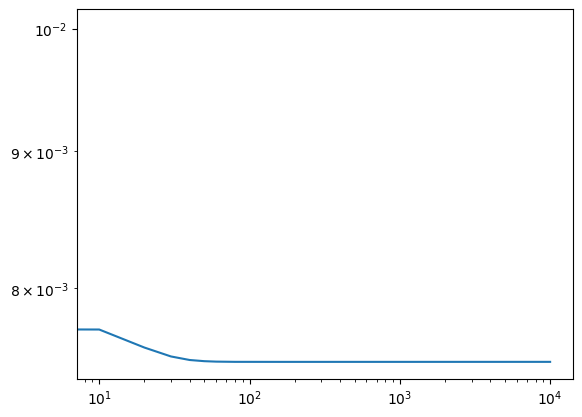

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


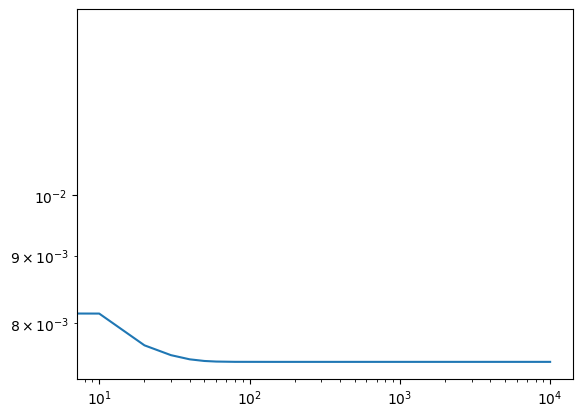

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


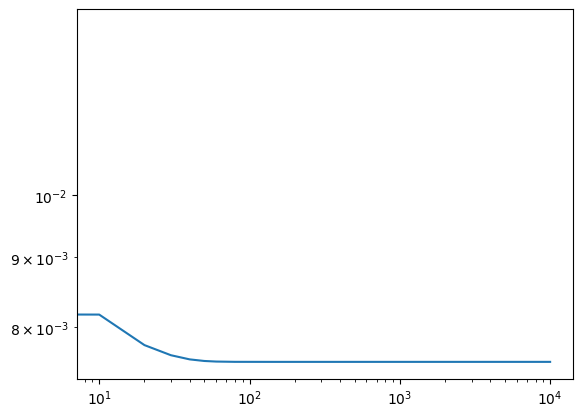

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


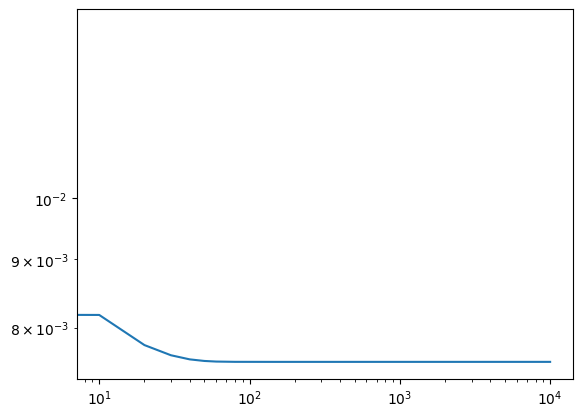

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


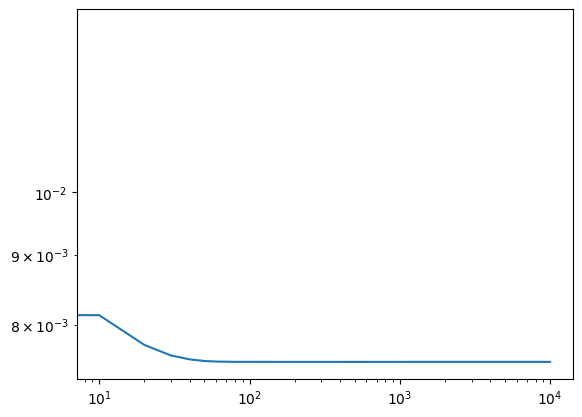

tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


In [9]:
A_post = torch.nn.Parameter(torch.eye(M))

def forward(params, W1):
    return W1 @ params[0]

params = [A_post]
exp(params, forward)

### Mult Pre r

##### Rank 1#####
tensor(0.9887, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9720, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9392, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8775, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7647, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5744, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2915, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.3776e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.0706e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)


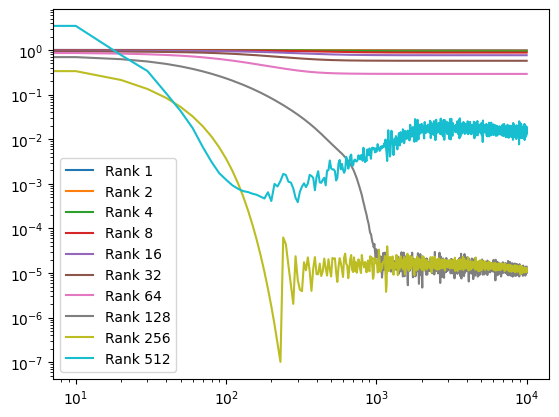

##### Rank 1#####
tensor(1.0022, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9852, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9525, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8896, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7750, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5824, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2949, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.0624e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.1444e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)


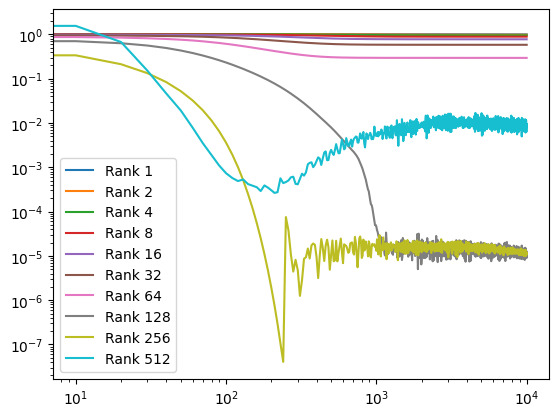

##### Rank 1#####
tensor(0.9886, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9722, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9401, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8794, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7675, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5770, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2913, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(8.2160e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.1149e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)


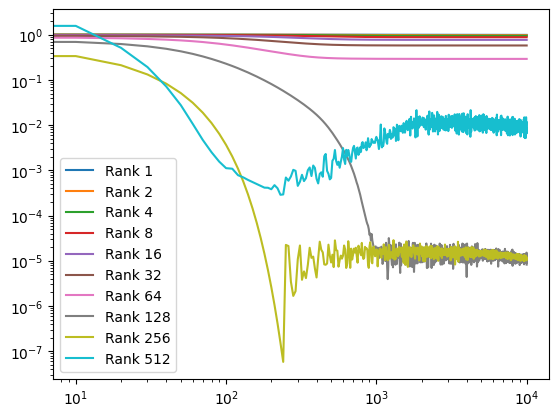

##### Rank 1#####
tensor(1.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9868, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9544, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8923, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7800, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5880, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2996, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.1053e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.1659e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)


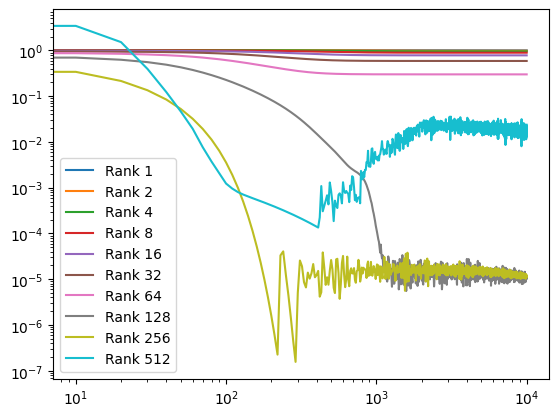

##### Rank 1#####
tensor(0.9910, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9744, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9419, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8802, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7685, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5779, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2930, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.2069e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.0937e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(0.2441, device='cuda:0', grad_fn=<MseLossBackward0>)


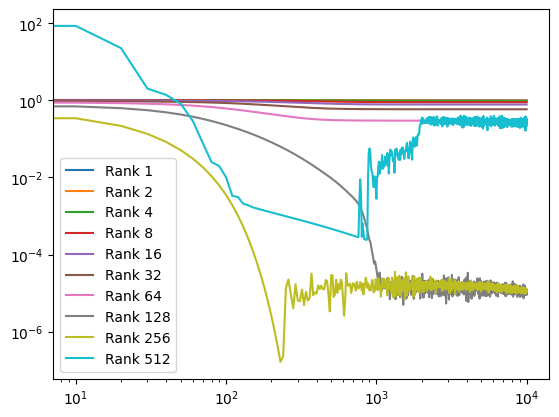

In [10]:
def forward(params, W1):
    return params[0] @ (params[1] @ W1)

def init(params):
    init_mult_lora_matrices(params[0], params[1])

set_shift_indices(N,N)
rank_exp([N,N], forward, init)

### Mult Post r

##### Rank 1#####
tensor(0.9888, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9720, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9394, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8779, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7657, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5763, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2953, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)


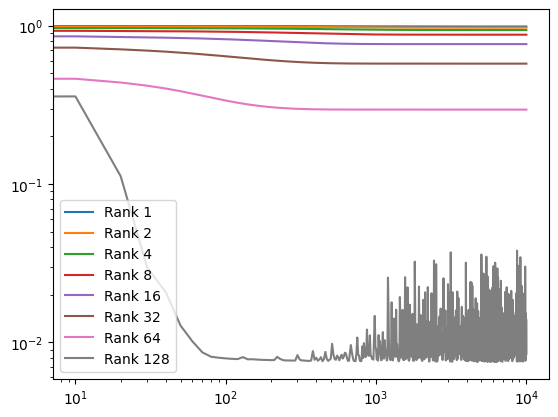

##### Rank 1#####
tensor(1.0023, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9854, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9527, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8901, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7760, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5843, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2986, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)


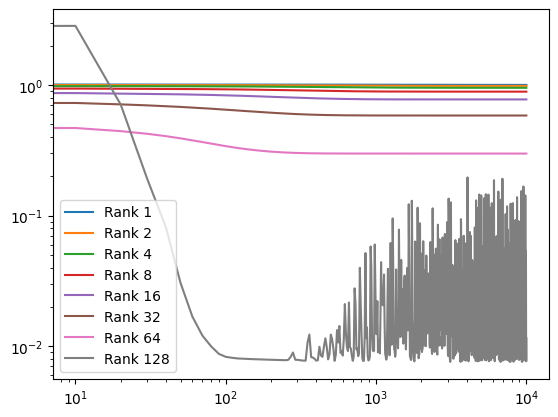

##### Rank 1#####
tensor(0.9887, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9723, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9403, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8799, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7684, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5789, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2951, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)


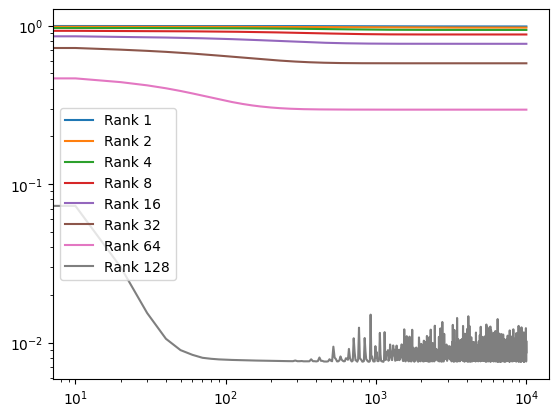

##### Rank 1#####
tensor(1.0035, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9869, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9546, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8928, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7809, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5899, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.3034, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0808, device='cuda:0', grad_fn=<MseLossBackward0>)


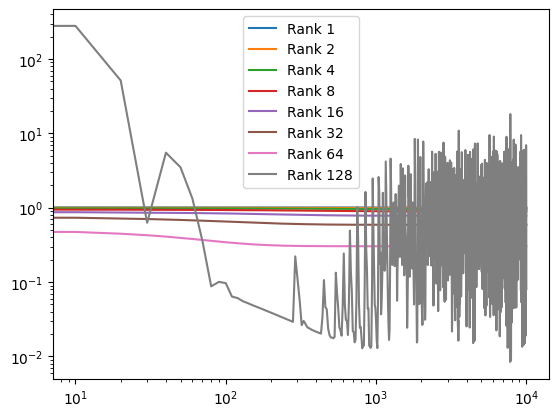

##### Rank 1#####
tensor(0.9911, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.9745, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.9422, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.8807, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.7694, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.5798, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.2968, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)


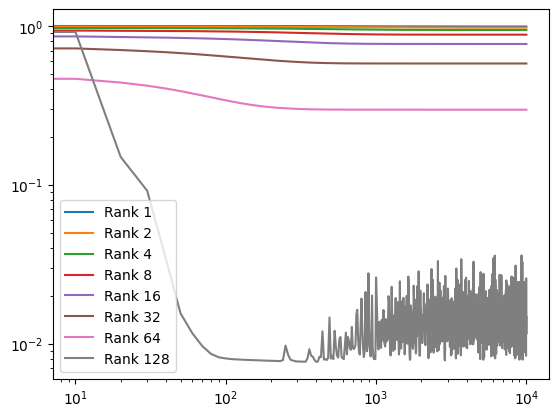

In [11]:
def forward(params, W1):
    return (W1 @ params[0]) @ params[1]

def init(params):
    init_mult_lora_matrices(params[0], params[1])

set_shift_indices(M,M)
rank_exp([M,M], forward, init)

### LoRA

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(4.0666e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


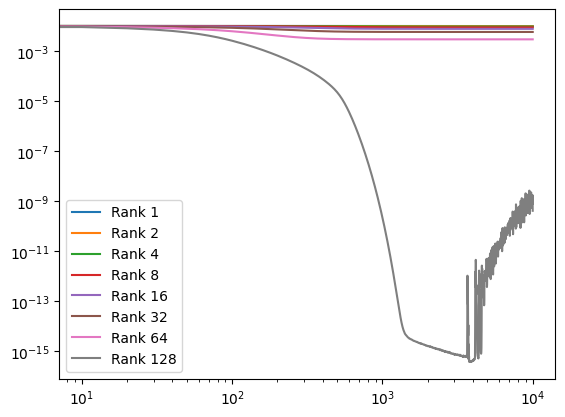

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.1903e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


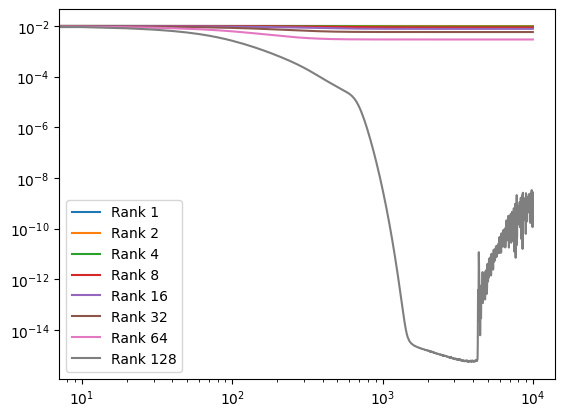

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.0898e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


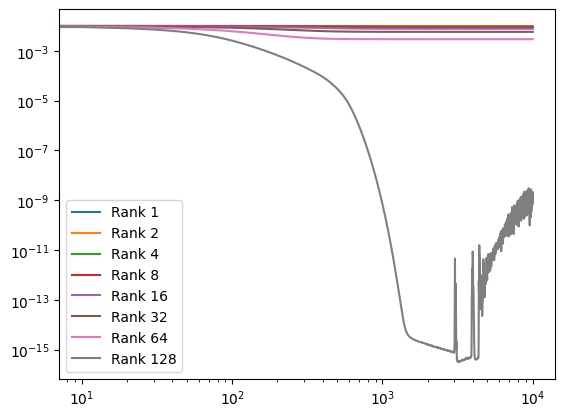

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(5.0767e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


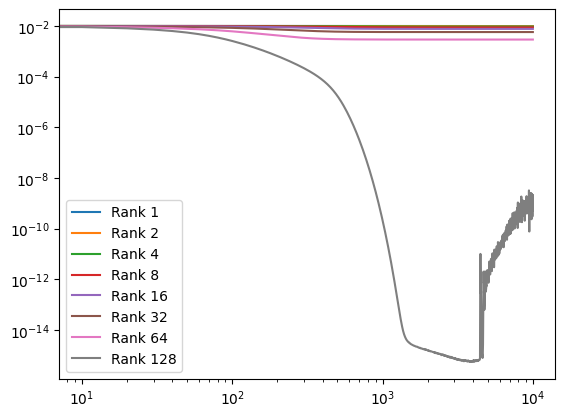

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(8.7748e-10, device='cuda:0', grad_fn=<MseLossBackward0>)


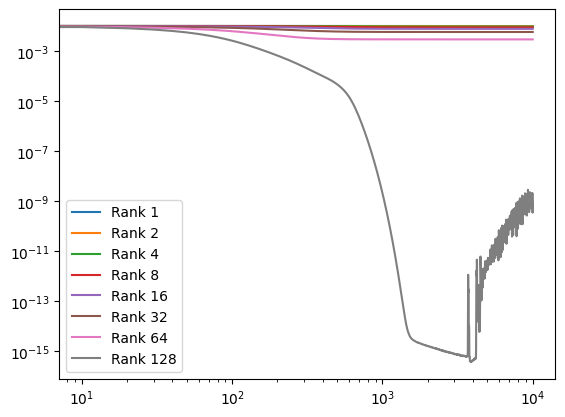

In [12]:
def forward(params, W1):
    return W1 + params[0] @ params[1]

def init(params):
    init_lora_matrices(params[0], params[1])

rank_exp([N,M], forward, init)

### LoRA - shift

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.4065e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


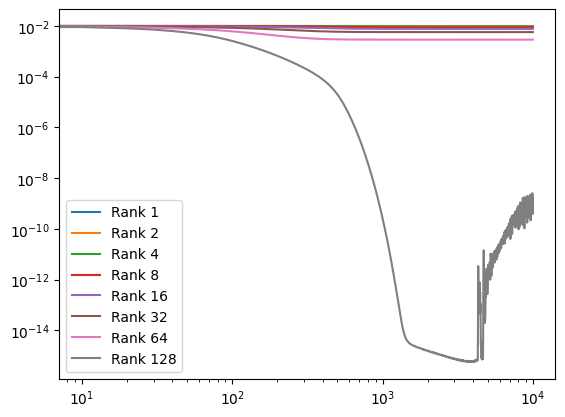

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.1448e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


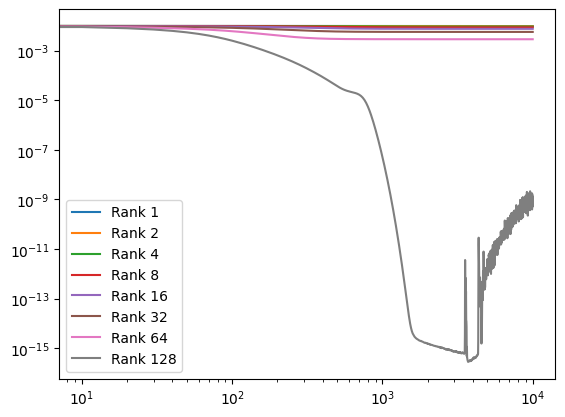

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.4036e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


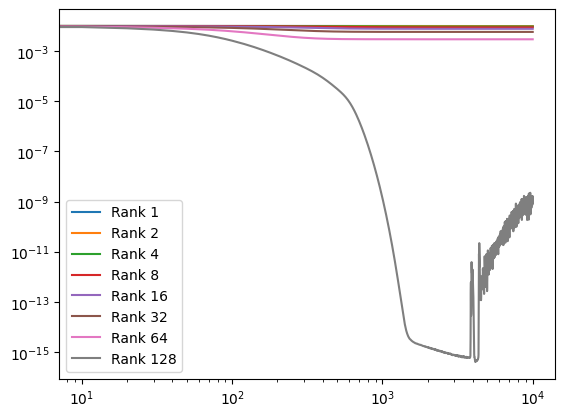

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.1070e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


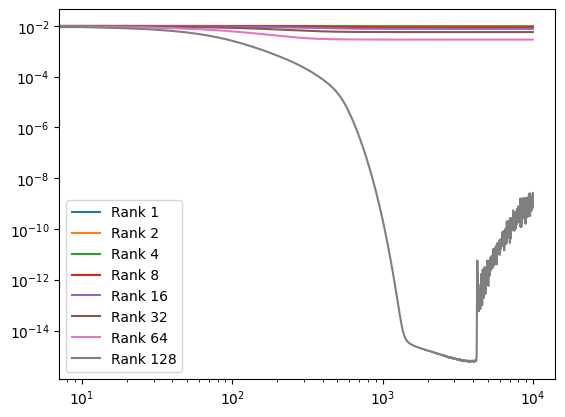

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.3590e-09, device='cuda:0', grad_fn=<MseLossBackward0>)


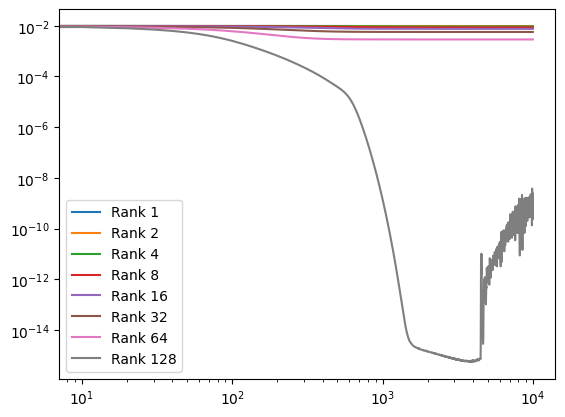

In [13]:
def forward(params, W1):
    return W1 + shift(params[0] @ params[1])

def init(params):
    init_lora_matrices(params[0], params[1])

set_shift_indices(N,M)
rank_exp([N,M], forward, init)

### Pre Mult r - shift

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.3635e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.1244e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.9093e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.2657e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


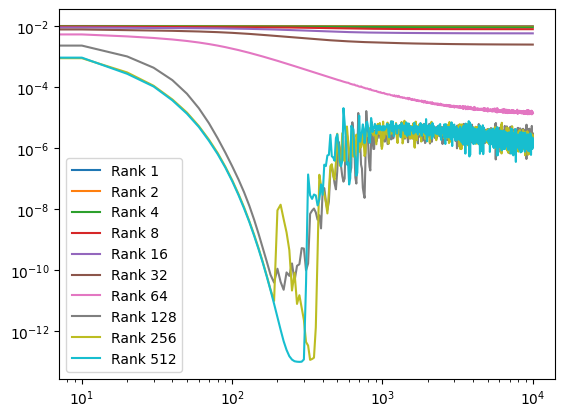

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.5490e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.5781e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.2530e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.4694e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


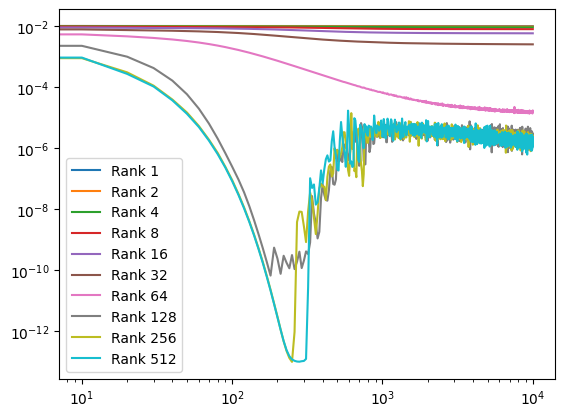

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.2834e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.5654e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(9.3661e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.7903e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


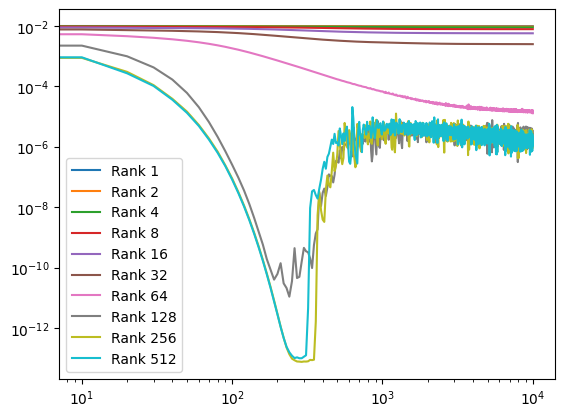

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.4501e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(1.6153e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(1.3977e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.1622e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


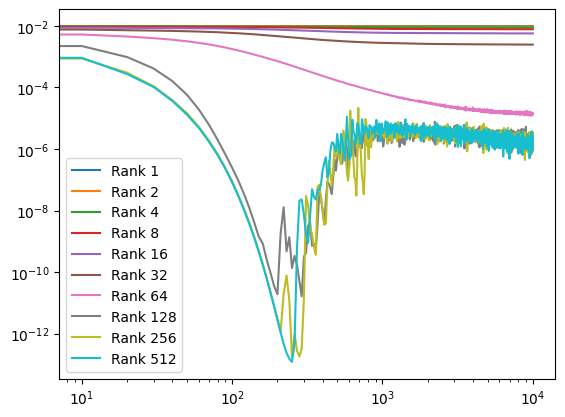

##### Rank 1#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(1.2501e-05, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(2.7327e-06, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 256#####
tensor(9.2946e-07, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 512#####
tensor(1.4457e-06, device='cuda:0', grad_fn=<MseLossBackward0>)


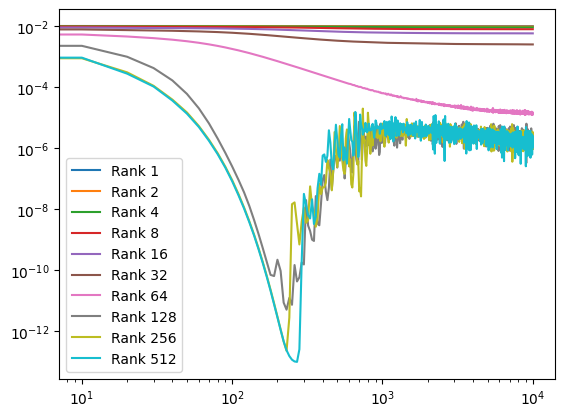

In [14]:
def forward(params, W1):
    return shift(params[0] @ params[1]) @ W1

def init(params):
    init_shift_lora_matrices(params[0], params[1])

set_shift_indices(N,N)
rank_exp([N,N], forward, init)

### Post Mult r - shift

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


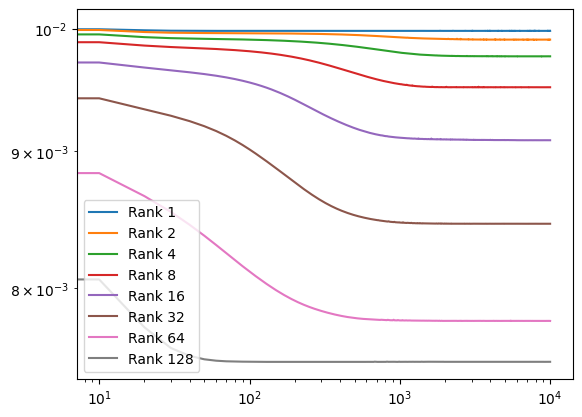

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


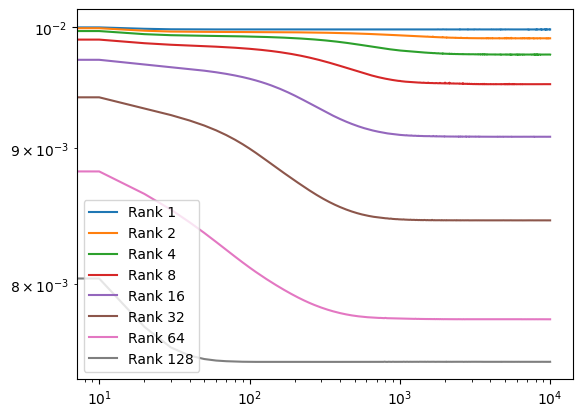

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


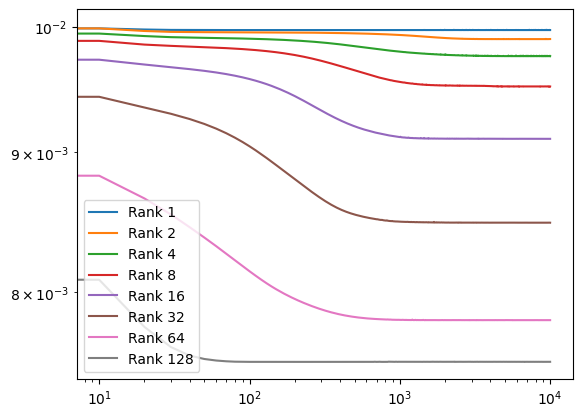

##### Rank 1#####
tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


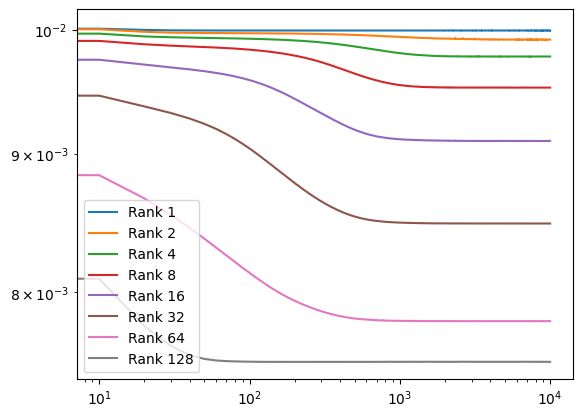

##### Rank 1#####
tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 2#####
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 4#####
tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 8#####
tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 16#####
tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 32#####
tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 64#####
tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)
##### Rank 128#####
tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)


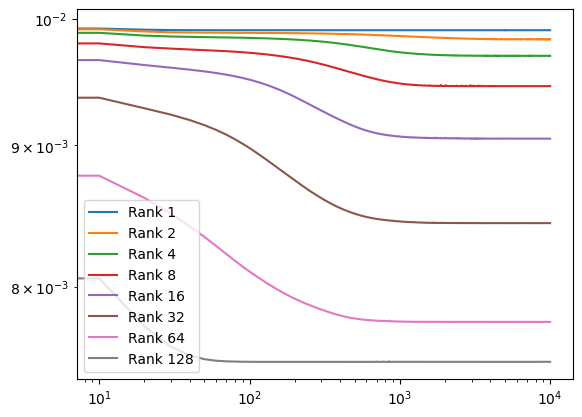

In [15]:
def forward(params, W1):
    return W1 @ shift(params[0] @ params[1])

def init(params):
    init_shift_lora_matrices(params[0], params[1])

set_shift_indices(M,M)
rank_exp([M,M], forward, init)